# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

Deep Q Learning Neural network (DQN) is used for training in this nodebook.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [14]:
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86_64")

OSError: handle is closed

ERROR:root:Exception calling application: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/ubuntu/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "/home/ubuntu/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/home/ubuntu/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [11]:
# Don't close the environment to use it for next experiments
# After close, it is impossible to reload environment on this Unity version.
# env.close()

### 4. Deep Q Learning

This is implementation of Deep Q Learning (DQN).

#### 4.1. Import modules

In [12]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#### 4.2. Reset environment for next test

In [13]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# number of state space 
state = env_info.vector_observations[0]
state_size = len(state)

UnityEnvironmentException: No Unity environment is loaded.

#### 4.3. Load agent

In [7]:
from dqn_agent import Agent

dqn_agent = Agent(state_size=state_size, action_size=action_size, seed=0)

#### 4.4 Define training method

In [8]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, agent=None):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    avg_checked = False
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)

            state = next_state                             # roll over the state to next time step
            score += reward                                # update the score
            if done:                                       # exit loop if episode finished
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score

        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if not avg_checked and np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model_dqn.pth')
            avg_checked = True
            break
            
    return scores

#### 4.5 Execute DQN method and plot the result

In [9]:
import time

start_time = time.time()
dqn_scores = train(agent=dqn_agent)
print('\nTraining time = {:.2f}s'.format(time.time() - start_time))

TEST1
tensor([[-0.0428,  0.1515, -0.0266, -0.0468],
        [-0.1133,  0.2875, -0.1179,  0.1362],
        [-0.0907,  0.3117, -0.1097,  0.1101],
        [ 0.0655,  0.0806,  0.0271, -0.0524],
        [-0.0388,  0.1594, -0.0161, -0.0208],
        [ 0.0503,  0.0803,  0.0070, -0.1028],
        [ 0.1250,  0.1021,  0.0744, -0.0663],
        [-0.0709,  0.2522, -0.1043,  0.1056],
        [-0.0714,  0.2194, -0.0922,  0.0779],
        [ 0.1126,  0.1063,  0.0597, -0.0851],
        [-0.0332,  0.1064, -0.0349, -0.0437],
        [-0.0515,  0.1163, -0.0114, -0.0613],
        [ 0.1116,  0.0924,  0.0654, -0.0506],
        [ 0.0601,  0.1473,  0.0829, -0.2271],
        [-0.0666,  0.2794, -0.0552,  0.1050],
        [-0.0189,  0.1354, -0.0326, -0.0761],
        [-0.0711,  0.1906, -0.0782, -0.0013],
        [ 0.1122,  0.0904,  0.0403, -0.1027],
        [ 0.1461,  0.0890, -0.0010, -0.1508],
        [ 0.0066,  0.0809, -0.0776, -0.0824],
        [ 0.0984,  0.1582,  0.1559, -0.2150],
        [ 0.0385,  0.1400,  

TEST1
tensor([[ 0.1119,  0.0924,  0.0656, -0.0503],
        [ 0.1698,  0.1344,  0.0937, -0.1712],
        [ 0.0533,  0.0676, -0.0330, -0.1043],
        [ 0.0862,  0.0902,  0.0185, -0.1701],
        [ 0.0605,  0.1474,  0.0834, -0.2264],
        [ 0.1293,  0.1178,  0.1056, -0.1984],
        [ 0.0656,  0.0806,  0.0273, -0.0522],
        [-0.0708,  0.2192, -0.0918,  0.0782],
        [ 0.0937,  0.1061,  0.0387, -0.2172],
        [ 0.0324,  0.0554, -0.0697, -0.0993],
        [ 0.0989,  0.1583,  0.1565, -0.2142],
        [-0.0259,  0.1652, -0.0086,  0.0466],
        [-0.0699,  0.1721, -0.0563,  0.0731],
        [ 0.0893,  0.0843,  0.0089, -0.1639],
        [-0.0520,  0.1535, -0.0533, -0.0826],
        [-0.0376,  0.2304, -0.0422,  0.0487],
        [ 0.1080,  0.1552,  0.0782, -0.2577],
        [-0.1234,  0.1580, -0.0957,  0.0571],
        [-0.1135,  0.2410, -0.0953,  0.1104],
        [ 0.0280,  0.0774, -0.0277, -0.1490],
        [-0.0333,  0.1171, -0.0639, -0.0440],
        [-0.0656,  0.0816,  

tensor([[ 0.1083,  0.0576,  0.0942, -0.1455],
        [ 0.0404,  0.0884, -0.0044, -0.1418],
        [ 0.0801,  0.0906,  0.0521, -0.1689],
        [-0.0187,  0.1459, -0.0386, -0.0029],
        [ 0.1555,  0.1348,  0.1030, -0.2351],
        [ 0.0395,  0.1401,  0.1145, -0.1587],
        [ 0.0435,  0.0854,  0.0906, -0.0697],
        [ 0.0463,  0.0578,  0.0044, -0.0687],
        [ 0.0567,  0.1170,  0.0534, -0.1478],
        [ 0.0075,  0.1621,  0.0164, -0.0750],
        [ 0.1808,  0.1488,  0.1433, -0.1905],
        [-0.0674,  0.1025, -0.0576, -0.0224],
        [-0.0073,  0.2181, -0.0572, -0.0649],
        [-0.0627,  0.1465, -0.0817,  0.0156],
        [ 0.1086,  0.1116,  0.0839, -0.2138],
        [ 0.0610,  0.0941, -0.0097, -0.1178],
        [-0.0687,  0.1717, -0.0557,  0.0736],
        [-0.0871,  0.3106, -0.1074,  0.1116],
        [ 0.1107,  0.0981,  0.0779, -0.1482],
        [ 0.0661,  0.0806,  0.0277, -0.0518],
        [ 0.0761,  0.1360,  0.1155, -0.1974],
        [ 0.0890,  0.0935, -0.0235

tensor([ 0,  1,  1,  1,  0,  1,  1,  1,  0,  0,  1,  0,  1,  0,
         1,  1,  1,  1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  0,  1,  1,  1,  0,  1], device='cuda:0')
Test4
tensor([[ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        

TEST1
tensor([[-0.0665,  0.1446, -0.0679,  0.1031],
        [-0.1149,  0.1557, -0.0916,  0.0595],
        [ 0.0654,  0.0533,  0.0159, -0.1154],
        [-0.0607,  0.2465, -0.0360,  0.1065],
        [ 0.1372,  0.1305,  0.0672, -0.1475],
        [-0.0212,  0.1069, -0.0431, -0.0555],
        [-0.0934,  0.2396, -0.1238,  0.0509],
        [ 0.0264,  0.0528, -0.0082, -0.1218],
        [-0.0296,  0.1705, -0.0615, -0.1026],
        [-0.0573,  0.2769, -0.0494,  0.1094],
        [-0.0385,  0.1509, -0.0238, -0.0444],
        [ 0.1141,  0.0925,  0.0670, -0.0474],
        [ 0.0431,  0.0461,  0.0326, -0.0655],
        [-0.0612,  0.2487, -0.0998,  0.1078],
        [ 0.1316,  0.0848,  0.0289, -0.1101],
        [ 0.0241,  0.0826, -0.0085, -0.1118],
        [ 0.0511,  0.1368,  0.0515, -0.1900],
        [ 0.0568,  0.1263,  0.0426, -0.2219],
        [-0.0335,  0.2316, -0.0407,  0.0523],
        [ 0.0624,  0.1263,  0.0043, -0.0965],
        [ 0.0908,  0.0852,  0.0107, -0.1587],
        [ 0.0520,  0.1286,  

(tensor([ 0.1445,  0.0782,  0.1216,  0.1549,  0.1327,  0.1785,  0.0914,
         0.1430,  0.1502,  0.0912,  0.3069,  0.2867,  0.1465,  0.1639,
         0.1296,  0.0661,  0.0916,  0.0950,  0.1513,  0.0583,  0.2474,
         0.1629,  0.1423,  0.1559,  0.0705,  0.1129,  0.1436,  0.2443,
         0.1876,  0.1722,  0.2456,  0.1147,  0.2401,  0.1186,  0.1349,
         0.2969,  0.1529,  0.0814,  0.2337,  0.1145,  0.0723,  0.1011,
         0.1125,  0.1878,  0.0651,  0.0552,  0.1123,  0.0826,  0.1792,
         0.0630,  0.1091,  0.2238,  0.1086,  0.0724,  0.0897,  0.1445,
         0.1051,  0.0890,  0.2727,  0.1164,  0.2310,  0.1121,  0.0813,
         0.1242], device='cuda:0'), tensor([ 1,  1,  1,  1,  0,  1,  0,  2,  1,  0,  1,  1,  1,  1,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         0,  0,  1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1], device='cuda:0'))
Test3
ten

TEST1
tensor([[-0.0286,  0.2302, -0.0376,  0.0543],
        [-0.1064,  0.3039, -0.1317,  0.1480],
        [ 0.1012,  0.1614,  0.1579, -0.2031],
        [ 0.1132,  0.0918,  0.0343, -0.1285],
        [ 0.0334,  0.0384, -0.0167, -0.1250],
        [ 0.1017,  0.0991, -0.0030, -0.1348],
        [ 0.0572,  0.1273,  0.0429, -0.2183],
        [ 0.0158,  0.1503, -0.0199, -0.0138],
        [-0.0318,  0.0660, -0.0099, -0.1190],
        [ 0.1822,  0.1520,  0.1447, -0.1812],
        [-0.0889,  0.2385, -0.1212,  0.0529],
        [-0.0196,  0.1301, -0.0375, -0.0783],
        [-0.0600,  0.1007, -0.0537, -0.0197],
        [ 0.1811,  0.1091,  0.1537, -0.1587],
        [ 0.0549,  0.0818,  0.0092, -0.0985],
        [ 0.0185,  0.0816, -0.0269, -0.0821],
        [ 0.0104,  0.0809, -0.0746, -0.0789],
        [ 0.0637,  0.1495,  0.0854, -0.2166],
        [ 0.0095,  0.1396, -0.0670,  0.0196],
        [-0.0443,  0.0653,  0.0085, -0.0703],
        [-0.0065,  0.1447, -0.0230, -0.0587],
        [ 0.0740,  0.0783, -

(tensor([ 0.0826,  0.1531,  0.0729,  0.1722,  0.1537,  0.1676,  0.1770,
         0.1119,  0.0811,  0.1413,  0.1129,  0.1525,  0.2377,  0.0980,
         0.2689,  0.0959,  0.1911,  0.1300,  0.1810,  0.2937,  0.1249,
         0.0779,  0.2356,  0.1303,  0.1047,  0.1209,  0.0819,  0.3051,
         0.1349,  0.0654,  0.0588,  0.1501,  0.2572,  0.2380,  0.1048,
         0.1308,  0.0822,  0.0860,  0.0661,  0.3034,  0.1148,  0.1474,
         0.1549,  0.1620,  0.1331,  0.0664,  0.1707,  0.1736,  0.1505,
         0.0910,  0.1522,  0.0388,  0.2708,  0.3030,  0.1684,  0.2423,
         0.0980,  0.0631,  0.0918,  0.0925,  0.1378,  0.1622,  0.0648,
         0.0708], device='cuda:0'), tensor([ 1,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  1,  1,  0,
         1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,
         1,  1,  0,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,
         1,  0,  0,  1,  0,  1,  0,  0], device='cuda:0'))
Test3
ten

Episode 1	Average Score: -1.00TEST1
tensor([[ 0.0455,  0.1200,  0.0410, -0.1747],
        [ 0.0318,  0.1520,  0.0020, -0.0608],
        [-0.0237,  0.2288, -0.0344,  0.0567],
        [-0.0456,  0.2718, -0.0424,  0.1148],
        [-0.0485,  0.2698, -0.0281,  0.1317],
        [-0.0665,  0.2636, -0.1089,  0.2002],
        [ 0.0206,  0.0821, -0.0255, -0.0811],
        [-0.0271,  0.1300, -0.0416, -0.1022],
        [-0.0543,  0.1056, -0.0121, -0.1366],
        [ 0.0903,  0.0981,  0.0497, -0.1187],
        [ 0.0958,  0.1080,  0.0412, -0.2038],
        [ 0.0759,  0.0784, -0.0256, -0.0431],
        [-0.0398,  0.1421, -0.0166, -0.0226],
        [-0.0319,  0.1497, -0.0205, -0.0405],
        [-0.0035,  0.1160, -0.0678, -0.0362],
        [ 0.0713,  0.0362, -0.0618, -0.1120],
        [ 0.0820,  0.0524,  0.0225, -0.0681],
        [ 0.1328,  0.1256,  0.1419, -0.1704],
        [ 0.0676,  0.0450, -0.0174, -0.0637],
        [ 0.0602,  0.1211,  0.0491, -0.2142],
        [-0.0187,  0.0703, -0.0203, -0.0685]

TEST1
tensor([[-0.0237,  0.0977, -0.0376, -0.0235],
        [ 0.1019,  0.1693,  0.0326, -0.0339],
        [-0.0986,  0.2238, -0.0401,  0.0683],
        [ 0.0831,  0.0527,  0.0234, -0.0672],
        [-0.0146,  0.1128, -0.0261, -0.0319],
        [ 0.0479,  0.0519,  0.0122, -0.0888],
        [ 0.0465,  0.0735, -0.0208, -0.0586],
        [ 0.0925,  0.0879,  0.0125, -0.1525],
        [-0.0385,  0.1420, -0.0159, -0.0219],
        [ 0.0372,  0.1041, -0.0272, -0.0766],
        [ 0.0390,  0.0777, -0.0297, -0.0301],
        [-0.0166,  0.0778, -0.0853, -0.1317],
        [ 0.0986,  0.1293, -0.0033, -0.0416],
        [-0.0139,  0.1474, -0.0526, -0.0183],
        [ 0.1045,  0.1296,  0.1422, -0.1710],
        [ 0.0772,  0.0998,  0.0164, -0.0587],
        [ 0.0378,  0.0550, -0.0646, -0.0930],
        [ 0.1184,  0.0937,  0.0689, -0.0434],
        [-0.0255,  0.1300, -0.0409, -0.1014],
        [ 0.0525,  0.1388,  0.0523, -0.1824],
        [ 0.0512,  0.0998, -0.0120, -0.0624],
        [ 0.0543,  0.0882,  

tensor([[ 0.0387,  0.1635, -0.0064, -0.0569],
        [ 0.1001,  0.0722,  0.0647, -0.1638],
        [-0.0274,  0.1588, -0.0089, -0.0150],
        [-0.0529,  0.1262, -0.0453, -0.0585],
        [ 0.1117,  0.0616,  0.0965, -0.1356],
        [ 0.1192,  0.0940,  0.0692, -0.0426],
        [ 0.0672,  0.0563, -0.0315, -0.0601],
        [-0.0159,  0.1553,  0.0061, -0.0430],
        [ 0.0306,  0.0537, -0.0057, -0.1178],
        [ 0.0483,  0.0747, -0.0279, -0.0827],
        [ 0.0375,  0.0720, -0.0328, -0.0687],
        [ 0.0452,  0.1270,  0.0266, -0.0614],
        [-0.0240,  0.1405, -0.0253, -0.0032],
        [-0.0352,  0.1451, -0.0626, -0.0305],
        [ 0.0883,  0.0984,  0.0522, -0.1029],
        [ 0.0460,  0.1207,  0.0413, -0.1721],
        [ 0.1715,  0.0833,  0.0530, -0.1221],
        [-0.0286,  0.1491, -0.0190, -0.0387],
        [ 0.0590,  0.0838,  0.0110, -0.0947],
        [-0.0902,  0.2322, -0.0823,  0.1190],
        [ 0.0377,  0.1007,  0.0687, -0.1295],
        [-0.0177,  0.1377, -0.0605

tensor([[ 0],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 2],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 0],
        [ 0],
        [ 1],
        [ 1],
        [ 0],
        [ 1],
        [ 0],
        [ 1],
        [ 1],
        [ 1],
        [ 1]], device='cuda:0')
TestEnd
TEST1
tensor([[ 0.1139,  0.0895,  0.0625, -0.1842],
        [-0.0451,  0.1828,

KeyboardInterrupt: 

In [14]:
import pandas as pd

def plot_scores(scores):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    ax.axhline(13, c="red", alpha=0.5)
    
    rolling_window = 100
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, c='green', );
    
    plt.show()

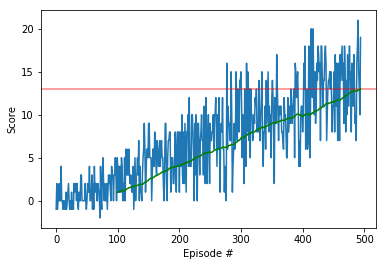

In [15]:
plot_scores(dqn_scores)

#### 4.6 Diplay how an agent moves
Below codes executes on Windows.
It shows agents how to move by training result.
Training environment is AWS, and execution environment is Windows due to display reason.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [18]:
def test(agent, weights_filename, max_t=1000):
    # load weights infomration form saved file
    # TODO: this should be extracted to agent method
    agent.qnetwork_local.load_state_dict(torch.load(weights_filename))
    agent.qnetwork_target.load_state_dict(torch.load(weights_filename))

    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0

    for t in range(max_t):
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = env_info.vector_observations[0]        # roll over the state to next time step
        score += reward                                # update the score
        if done:                                       # exit loop if episode finished
            break 
    
    print('Score: {:.2f}'.format(score))

In [19]:
test(dqn_agent, 'model_dqn.pth')

Score: 14.00


### 5. Double DQN (DDQN)

This is implementation of Deep DQN (DDQN).

In [ ]:
# TODO: Implementaion